In [4]:
# Numpy
import numpy as np
import pandas as pd
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats
import scipy.interpolate

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils, sklearn.model_selection, sklearn.gaussian_process, sklearn.linear_model
import optunity
import statsmodels.nonparametric.smoothers_lowess

# Various Python tricks and libraries
import requests
import time
import functools
import operator
import collections
from tqdm import tqdm, tqdm_notebook, tnrange
import dill as pickle
import IPython
import gc

# Parallel
import joblib
import multiprocessing

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# nanaimo，不掐头

In [5]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [6]:
jobs = read_log()

In [ ]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return None
        
    # 零、有空位，就不用等。
    # if rj.NNodes.sum() + tj.NNodes <= 36:
    #     # 几乎总是tj.Waited < 0.005
    #     return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

In [15]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [16]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)


/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [17]:
len(normalize_analyses)

12790

In [18]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [19]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 10000
        TEST = 3000
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -3:
            training_index = range(0, N * 4 / 5)
            test_index = range(N * 4 / 5, N) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

HBox(children=(IntProgress(value=0, max=11990), HTML(value=u'')))

<IPython.core.display.Javascript object>


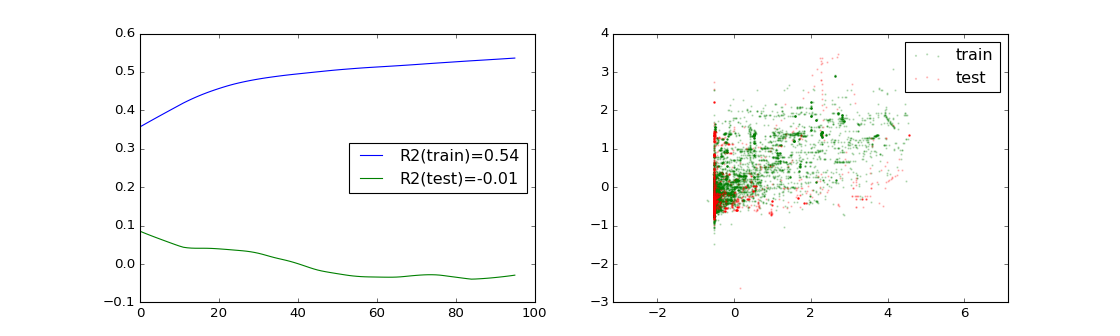

KeyboardInterrupt: 

Process PoolWorker-103:
Process PoolWorker-104:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    task = get()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt


In [22]:
# random_split = -3
# tune lr and minibatch_size. note: total=100,000. visual suggests both are good.
# tune nn structure. 
# [3, 2] prob sees a P turning point. decreasing to [3] chokes both P's.

minibatch_size = 256
n_epochs = 300
ns_units = [25, 25]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [23]:
r2_trains, r2_tests = [], []

for cut in range(1, 8000, 500):

    train = normalize_analyses.iloc[:cut]
    test = normalize_analyses.iloc[cut:]
    X_train = train.drop('Waited', axis=1)
    y_train = train.Waited
    X_test = test.drop('Waited', axis=1)
    y_test = test.Waited

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    yhat_train = reg.predict(X_train)
    yhat_test = reg.predict(X_test)
    r2_trains.append(sklearn.metrics.r2_score(y_train, yhat_train))
    r2_tests.append(sklearn.metrics.r2_score(y_test, yhat_test))

<IPython.core.display.Javascript object>


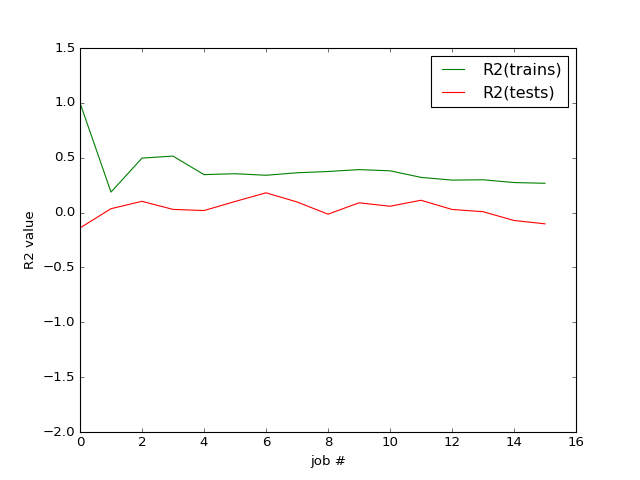

NameError: name 'patches' is not defined

In [24]:
fig, ax = plt.subplots()
ax.plot(r2_trains, label='R2(trains)', color='green')
ax.plot(r2_tests, label='R2(tests)', color='red')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('job #')
ax.set_ylabel('R2 value')
rect = patches.Rectangle((55000, 0.12), 85000, 0.35, edgecolor='none', facecolor='yellow')
ax.add_patch(rect)

# nanaimo，不掐头，短总样本时长

In [5]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [6]:
jobs = read_log()

In [29]:
jobs = jobs.iloc[-2000:]

In [30]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return None
        
    # 零、有空位，就不用等。
    # if rj.NNodes.sum() + tj.NNodes <= 36:
    #     # 几乎总是tj.Waited < 0.005
    #     return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

100%|██████████| 2000/2000 [00:00<00:00, 2598.97it/s]
Process PoolWorker-113:
Process PoolWorker-123:
Process PoolWorker-121:
Process PoolWorker-114:
Process PoolWorker-110:
Process PoolWorker-122:
Process PoolWorker-106:
Traceback (most recent call last):
Process PoolWorker-117:
Process PoolWorker-124:
Process PoolWorker-112:
Process PoolWorker-108:
Process PoolWorker-105:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most

  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
    racquire()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
    racquire()
    racquire()
KeyboardInterrupt
    task = get()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.p

In [31]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [32]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)


/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [33]:
len(normalize_analyses)

1922

In [34]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [35]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 10000
        TEST = 3000
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -3:
            training_index = range(0, N * 4 / 5)
            test_index = range(N * 4 / 5, N) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

HBox(children=(IntProgress(value=0, max=1801), HTML(value=u'')))

<IPython.core.display.Javascript object>


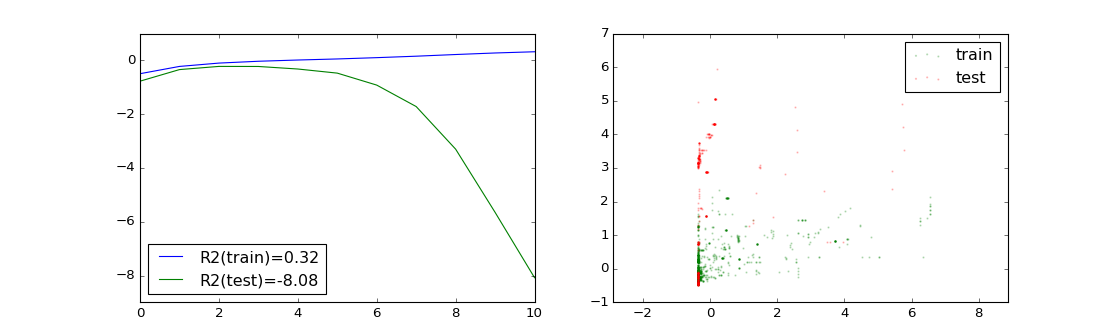

KeyboardInterrupt: 

Process PoolWorker-156:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-157:
Process PoolWorker-155:
Process PoolWorker-154:
Process PoolWorker-153:
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py

In [38]:
# random_split = -3
# tune lr and minibatch_size. note: total=100,000. visual suggests both are good.
# tune nn structure. 
# [3, 2] prob sees a P turning point. decreasing to [3] chokes both P's.

minibatch_size = 256
n_epochs = 300
ns_units = [2, 2]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [41]:
r2_trains, r2_tests = [], []

for cut in range(1, 1900, 50):

    train = normalize_analyses.iloc[:cut]
    test = normalize_analyses.iloc[cut:]
    X_train = train.drop('Waited', axis=1)
    y_train = train.Waited
    X_test = test.drop('Waited', axis=1)
    y_test = test.Waited

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    yhat_train = reg.predict(X_train)
    yhat_test = reg.predict(X_test)
    r2_trains.append(sklearn.metrics.r2_score(y_train, yhat_train))
    r2_tests.append(sklearn.metrics.r2_score(y_test, yhat_test))

<IPython.core.display.Javascript object>


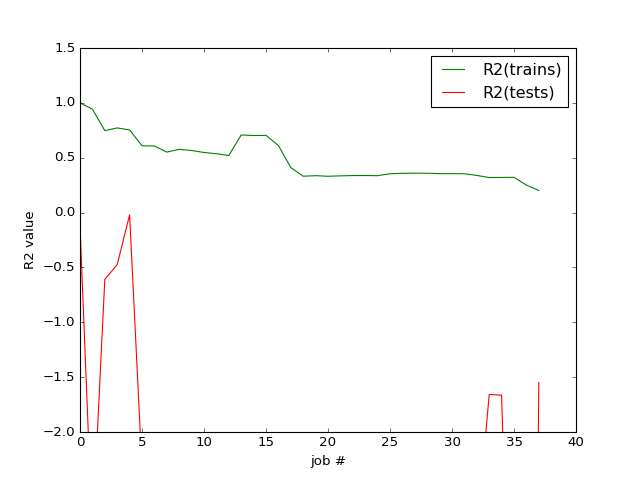

NameError: name 'patches' is not defined

In [42]:
fig, ax = plt.subplots()
ax.plot(r2_trains, label='R2(trains)', color='green')
ax.plot(r2_tests, label='R2(tests)', color='red')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('job #')
ax.set_ylabel('R2 value')
rect = patches.Rectangle((55000, 0.12), 85000, 0.35, edgecolor='none', facecolor='yellow')
ax.add_patch(rect)

# nanaimo，为什么edison就可以，解的不存在性（弱）

In [47]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.nanaimo.20170101-20180704.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'Submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    jobs.loc[:, 'Start'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    jobs.loc[:, 'End'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')

    jobs.loc[:, 'NNodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'Timelimit'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce')
    
    jobs.loc[:, 'Waited'] = (jobs.Start - jobs.Submit).values / pd.Timedelta('1h')

    # jobs = jobs[(np.abs(scipy.stats.zscore(jobs.loc[:,'Wait'].values / pd.Timedelta('1h'))) <3)]
    jobs = jobs.dropna()
    
    # jobs = jobs.sort_values(by = 'Submit')
    # 几乎总是sorted
    
    return jobs

In [48]:
jobs = read_log()

<IPython.core.display.Javascript object>


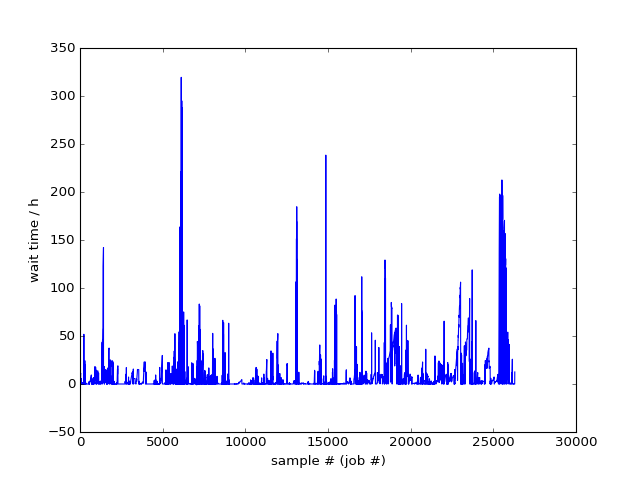

In [97]:
fig, ax = plt.subplots()
ax.set_xlabel('sample # (job #)')
ax.set_ylabel('wait time / h')
ax.plot(jobs.Waited)

In [49]:
def sample(tuple_):
    
    jobs, index, row = tuple_
    
    tj = thisjob = row
    now = tj.Submit
    
    rj = relatedjobs = jobs.loc[np.logical_and.reduce([jobs.index != index, jobs.Submit <= now, jobs.End > now])] # excludes thisjob, includes jobs submitted simultaneously but ranked earlier
    
    # 无关人等滚开
    if now < jobs.End.min() or index < 100:
        return None
        
    # 零、有空位，就不用等。
    # if rj.NNodes.sum() + tj.NNodes <= 36:
    #     # 几乎总是tj.Waited < 0.005
    #     return None
        
    # 一、各种descriptor
    analysis = pd.DataFrame([], index=[index])
    
    analysis.loc[:, 'NNodes'] = tj.NNodes
    analysis.loc[:, 'ETA']    = tj.Timelimit
    
    analysis.loc[:, 'Total_squeue_nnodes'] = rj.NNodes.sum()
    
    analysis.loc[:, 'Total_squeue_eta']    = rj.Timelimit.sum()
    
    analysis.loc[:, 'Self_job_in_squeue_percentage'] = 0 if len(rj)==0 else float(np.sum(rj.User == tj.User)) / len(rj)
    
    analysis.loc[:, 'Waited'] = tj.Waited
    
    return analysis
    
    
L = multiprocessing.Pool(processes=20).map(sample, [(jobs, index, row.copy()) for index, row in tqdm(jobs.iterrows(), total=len(jobs))])
analyses = pd.concat(L) # None is automatically ignored

100%|██████████| 24290/24290 [00:04<00:00, 4944.27it/s]
Process PoolWorker-172:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process PoolWorker-161:
Process PoolWorker-166:
    self._target(*self._args, **self._kwargs)
Process PoolWorker-159:
Process PoolWorker-173:
Process PoolWorker-158:
Process PoolWorker-168:
Process PoolWorker-165:
Process PoolWorker-162:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
Process PoolWorker-170:
Process PoolWorker-163:
Process PoolWorker-160:
Process PoolWorker-169:
Process PoolWorker-164:
Process PoolWorker-177:
Traceback (most recent call last):
Process PoolWorker-176:
Traceback (most recent call last):
Process PoolWorker-174:
Process PoolWorker-175:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process

  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    racquire()
    racquire()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
    return recv()
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
    racquire()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
KeyboardInte

In [50]:
# 去尾
analyses = analyses[analyses.Waited < analyses.Waited.quantile(q=0.97)].copy()

In [51]:
normalize_analyses = pd.DataFrame(
    sklearn.preprocessing.scale(
        analyses.apply(pd.to_numeric).values
    ), 
    index=analyses.index, 
    columns=analyses.columns
)


/home/xzhang1/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [52]:
len(normalize_analyses)

23467

In [53]:
class BetterYhatLive(object):
    
    def __init__(self, smoothen):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.line11, self.line12 = [], [] # note: line11 means ax1, line1
        self.smoothen = smoothen
        
    def update(self, y_train, yhat_train, y_test, yhat_test):
        self.line11.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line12.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line11))
            smoothline11 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line11, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline12 = statsmodels.nonparametric.smoothers_lowess.lowess(self.line12, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline11 = self.line11
            smoothline12 = self.line12
        #
        self.ax1.clear()
        self.ax1.plot(smoothline11, label='R2(train)=%.2f'%self.line11[-1])
        self.ax1.plot(smoothline12, label='R2(test)=%.2f'%self.line12[-1])
        self.ax1.legend(loc='best')
        self.ax2.clear()
        self.ax2.set_aspect('equal', adjustable='datalim')
        self.ax2.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax2.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax2.legend(loc='best')
        self.fig.canvas.draw()

In [54]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration and dying.
    Allows setting aside a test set.
    Progress bar.
    '''
    
    def __init__(self, df, minibatch_size, n_epochs, test_split, random_split, tqdm=False):
        self.minibatch_size = minibatch_size
        
        N = len(df)
        TRAIN = 10000
        TEST = 3000
        ALL = TRAIN + TEST
        if random_split == 2:
            M = np.random.randint(TRAIN, N)
            training_index = range(M - TRAIN, M)
            test_index = range(M - TEST, M)  
        elif random_split == 1:
            M = np.random.randint(ALL, N)
            all_index = range(M - ALL, M)
            test_index = np.random.choice(all_index, TEST, replace=False)
            training_index = list(set(all_index) - set(test_index))
        elif random_split == 0:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(N, TEST, replace=False)
        elif random_split == -0.1:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index = np.random.choice(list(set(range(N)) - set(training_index)), TEST, replace=False)
        elif random_split == -0.2:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-1, 0, 1]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.3:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-2, -1, 0, 1, 2]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -0.4:
            training_index = np.random.choice(N, TRAIN, replace=False)
            test_index_pool = set(range(N))
            for delta in [-3, -2, -1, 0, 1, 2, 3]:
                test_index_pool -= set((np.int32(training_index) + delta).tolist())
            test_index = np.random.choice(list(test_index_pool), TEST, replace=False)
        elif random_split == -1:
            training_index = np.random.choice(range(0, N * 3 / 4), TRAIN, replace=False)
            test_index = np.random.choice(range(N * 3 / 4 + 20, N), TEST, replace=False)
        elif random_split == -2:
            M = np.random.randint(TRAIN, N - TEST * 2)
            training_index = range(M - TRAIN, M)
            test_index = range(M + TEST, M + TEST * 2) 
        elif random_split == -3:
            training_index = range(0, N * 4 / 5)
            test_index = range(N * 4 / 5, N) 
        elif random_split == -9:
            M = np.random.randint(TRAIN, N - TEST)
            test_index = np.random.choice(N, TEST, replace=False)
            training_index = range(M - TRAIN, M)
        self.training_df = df.iloc[training_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        self.i = 0
        self.iMAX = n_epochs * len(self.training_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.iMAX, leave=False)
        
    def minibatch(self):
        if self.i > self.iMAX:
            self.i = 0
            raise StopIteration
        else:
            self.i += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.training_df)), self.minibatch_size, replace=False)
        return self.training_df.iloc[index, :-1].values, self.training_df.iloc[index, -1].values.reshape(-1, 1)
    
    def training_set(self):
        return self.training_df.iloc[:, :-1].values, self.training_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)

In [ ]:
# random_split = -3
# tune lr and minibatch_size. note: total=100,000. visual suggests both are good.
# tune nn structure. 
# [3, 2] prob sees a P turning point. decreasing to [3] chokes both P's.

minibatch_size = 256
n_epochs = 300
ns_units = [25, 25]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 5])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
training_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(normalize_analyses, minibatch_size, n_epochs, test_split=0.2, random_split=-3, tqdm=True)
b = BetterYhatLive(smoothen=True)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(training_op, feed_dict = {X: _X, y: _y})
        
        if m.i % 100 == 0:
            X_train, y_train = m.training_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

<IPython.core.display.Javascript object>


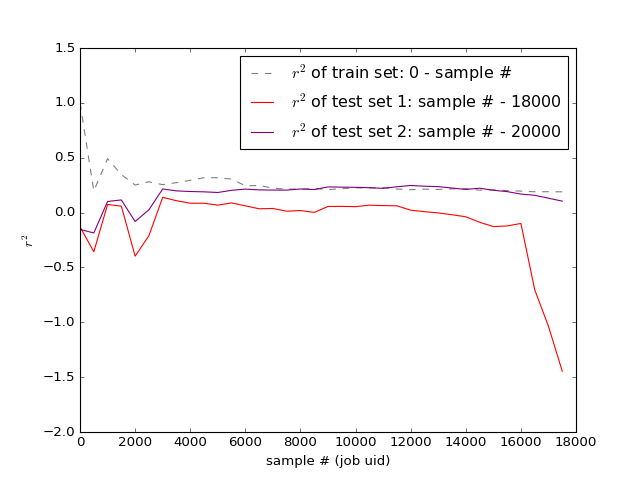

In [111]:
r2_trains, r2_tests1, r2_tests2 = [], [], []

XRANGE = range(1, 18000, 500)
for cut in XRANGE:

    train = normalize_analyses.iloc[:cut]
    test1 = normalize_analyses.iloc[cut:18000]
    test2 = normalize_analyses.iloc[cut:20000]
    X_train = train.drop('Waited', axis=1)
    y_train = train.Waited
    X_test1 = test1.drop('Waited', axis=1)
    y_test1 = test1.Waited
    X_test2 = test2.drop('Waited', axis=1)
    y_test2 = test2.Waited

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    yhat_train = reg.predict(X_train)
    yhat_test1 = reg.predict(X_test1)
    yhat_test2 = reg.predict(X_test2)
    r2_trains.append(sklearn.metrics.r2_score(y_train, yhat_train))
    r2_tests1.append(sklearn.metrics.r2_score(y_test1, yhat_test1))
    r2_tests2.append(sklearn.metrics.r2_score(y_test2, yhat_test2))

fig, ax = plt.subplots()
ax.plot(XRANGE, r2_trains, '--', label=r'$r^2$ of train set: 0 - sample #', color='grey', )
ax.plot(XRANGE, r2_tests1, label=r'$r^2$ of test set 1: sample # - 18000', color='red')
ax.plot(XRANGE, r2_tests2, label=r'$r^2$ of test set 2: sample # - 20000', color='purple')
ax.legend()
ax.set_ylim(-2, 1.5)
ax.set_xlabel('sample # (job uid)')
ax.set_ylabel('$r^2$')

In [112]:
analyses.Total_squeue_nnodes.mean()

126.17526739676993